# Trabajo de Mentoria - DiploDatos

**Grupo A**
    
Integrantes: 
    <li> Bruno Garcia
    <li> Nicolas Chiapello
    <li> Martin Peñas
    <li> Pame Pairo

## Vectorización: Tfidf

El conteo de la frecuencia de las palabras tiene la desventaja que palabras como “the”, “a”, “is” en inglés, son muy frecuentes y son poco informativas sobre el contenido real del documento.
Una alternativa que suele utilizarse es emplear Tfidf. Tf significa término de frecuencia mientras que tf-idf significa término de frecuencia multiplicado por la frecuencia inversa del documento.


In [17]:
import pandas as pd 
import numpy as np

df_news= pd.read_csv("data/feeling_procesado.csv").drop(columns="Unnamed: 0")
df_news.head(3)

,feeling,news,news_tokens,news_tokens_tagged
0,neutral,"According to Gran , the company has no plans t...","['accord', 'gran', 'company', 'plan', 'move', ...","[('accord', 'NN'), ('gran', 'VBD'), ('company'..."
1,neutral,Technopolis plans to develop in stages an area...,"['technopolis', 'plan', 'develop', 'stage', 'a...","[('technopolis', 'NN'), ('plan', 'NN'), ('deve..."
2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')..."


## *Aprendizaje Automático*

#### Train/Test Split

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(df_news.news_tokens, df_news.feeling, test_size=0.2, random_state=42)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features = 200

tfidf = TfidfVectorizer(#ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_features=max_features,
                        norm='l2')
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(3870, 200)
(968, 200)


Se analiza mediante una prueba de $\chi^2$ las palabras que están asociadas a cada nivel de sentimiento

In [35]:
category_codes = {
    'neutral': 0,
    'negative': 1,
    'positive': 2
}

df_news['Category_Code'] = df_news['feeling'].map(category_codes)

In [42]:
from sklearn.feature_selection import chi2

for noticia, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' sentimiento:".format(noticia))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
   # print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'negative' sentimiento:
  . Most correlated unigrams:
. loss
. eur
. mn
. fell
. decrease

# 'neutral' sentimiento:
  . Most correlated unigrams:
. period
. compare
. profit
. mn
. eur

# 'positive' sentimiento:
  . Most correlated unigrams:
. eur
. sign
. grow
. increase
. rise



In [47]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')

## Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Selección de parámetros
params = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

Logreg = LogisticRegression()
Logreg_clf = GridSearchCV(Logreg, params, cv=3, scoring='f1_macro', n_jobs=-1)
Logreg_clf.fit(features_train, labels_train)

In [19]:
best_Logreg = Logreg_clf.best_estimator_
print(best_Logreg)

LogisticRegression(penalty='none', solver='saga')


In [20]:
text = "Regresión Logística - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_Logreg.predict(features_test)))

Regresión Logística - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.50      0.45      0.48       120
     neutral       0.75      0.85      0.80       575
    positive       0.64      0.48      0.55       273

    accuracy                           0.70       968
   macro avg       0.63      0.59      0.61       968
weighted avg       0.69      0.70      0.69       968



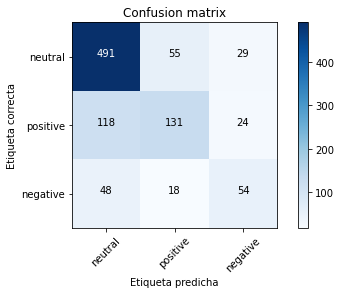

In [23]:
cm = confusion_matrix(labels_test, best_Logreg.predict(features_test),
                      labels=['neutral', 'positive', 'negative'])
plot_confusion_matrix(cm, ['neutral', 'positive', 'negative'])

## Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001],
    'fit_prior': [1, 0],
    'class_prior': [None, [0.33, 0.34, 0.33], [0.12790698, 0.58914729, 0.28294574]]
}

multinomNB = MultinomialNB()
multinomNB_clf = GridSearchCV(multinomNB, param_grid, scoring='f1_macro', cv=3)
multinomNB_clf.fit(features_train, labels_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001],
                         'class_prior': [None, [0.33, 0.34, 0.33],
                                         [0.12790698, 0.58914729, 0.28294574]],
                         'fit_prior': [1, 0]},
             scoring='f1_macro')

In [53]:
best_multinomNB = multinomNB_clf.best_estimator_
best_multinomNB

MultinomialNB(alpha=0.5, fit_prior=1)

In [54]:
text = "Naive Bayes - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_multinomNB.predict(features_test)))

Naive Bayes - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       575
           1       0.58      0.32      0.41       120
           2       0.60      0.31      0.41       273

    accuracy                           0.68       968
   macro avg       0.63      0.52      0.54       968
weighted avg       0.66      0.68      0.64       968



## SVM

In [24]:
from sklearn.svm import SVC

params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "C": [1,10,20]
}

svm = SVC()
svm_clf = GridSearchCV(svm, params, cv=3, scoring='f1_macro', n_jobs=-1)
svm_clf.fit(features_train, labels_train)

best_svm = svm_clf.best_estimator_

In [25]:
print(best_svm)

SVC(C=20, gamma='auto', kernel='linear')


In [26]:
text = "SVM - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_svm.predict(features_test)))

SVM - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.50      0.42      0.46       120
     neutral       0.73      0.86      0.79       575
    positive       0.63      0.43      0.51       273

    accuracy                           0.68       968
   macro avg       0.62      0.57      0.59       968
weighted avg       0.67      0.68      0.67       968



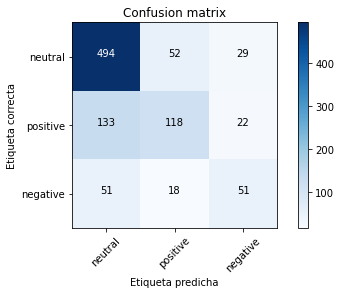

In [27]:
cm = confusion_matrix(labels_test, best_svm.predict(features_test),
                      labels=['neutral', 'positive', 'negative'])
plot_confusion_matrix(cm, ['neutral', 'positive', 'negative'])

## Random Forest

In [48]:
param_grid = {
    'max_depth': [10, 30, 60],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf':[2, 5, 10],
    'n_estimators': [10, 20, 40, 50]
   
}

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix,f1_score, make_scorer

# First create the base model to tune
rfc = RandomForestClassifier(random_state=42)
scorer = make_scorer(f1_score, average = "macro")

# Definition of the random search
random_search = GridSearchCV(estimator=rfc,
                             param_grid=param_grid,
                             scoring= scorer,
                             cv=3)

# Fit the random search model
random_search.fit(features_train, labels_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30, 60],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 4, 8, 10],
                         'n_estimators': [10, 20, 40, 50]},
             scoring=make_scorer(f1_score, average=macro))

In [60]:
random_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=60, min_samples_leaf=2,
                       n_estimators=50, random_state=42)

In [61]:
best_rfc = random_search.best_estimator_

In [62]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(criterion='entropy', max_depth=60, min_samples_leaf=2,
                       n_estimators=50, random_state=42)

In [63]:
rfc_pred = best_rfc.predict(features_test)

In [64]:
text = "Random Forest - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")

print(classification_report(labels_test,rfc_pred))

Random Forest - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.66      0.32      0.43       120
     neutral       0.72      0.91      0.80       575
    positive       0.60      0.41      0.49       273

    accuracy                           0.69       968
   macro avg       0.66      0.55      0.57       968
weighted avg       0.68      0.69      0.67       968



## KNeighborsClassifier

In [66]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    "n_neighbors": [1,2,3,4,5,6,7,8,15,20],
    "weights": ["uniform", "distance"],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"]
}

knn = KNeighborsClassifier()
knn_clf= GridSearchCV(knn, params, cv=3, scoring='f1_macro', n_jobs=-1)
knn_clf.fit(features_train, labels_train)

best_knn = knn_clf.best_estimator_

In [67]:
print(best_knn)

KNeighborsClassifier(n_neighbors=6, weights='distance')


In [68]:
text = "KNN - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")

print(classification_report(labels_test, best_knn.predict(features_test)))

KNN - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.56      0.31      0.40       120
     neutral       0.70      0.89      0.78       575
    positive       0.55      0.34      0.42       273

    accuracy                           0.66       968
   macro avg       0.60      0.51      0.53       968
weighted avg       0.64      0.66      0.63       968

